## The Project Notebook 

The code lines that start with "!" denote terminal code. git clone command clones a repository from Github, in this case, specifically the AI4All repo.

In [ ]:
!git clone https://github.com/Srinivas-R/AI4ALL.git

fatal: destination path 'AI4ALL' already exists and is not an empty directory.


Import necessary packages, the deep learning framework used in this project is Keras. We give you the augment_data function for convenience - For each image, it randomly chooses from one of the following augmentations (flipping vertically, flipping horizontally, blurring, and rotation up to 30 degrees).

In [ ]:
import numpy as np
import pickle
import cv2
import os
from os import listdir
from PIL import Image
from scipy.ndimage.interpolation import rotate
from scipy.ndimage import gaussian_filter
from collections import defaultdict
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from AI4ALL.utils import split_train_test
import string

def load_data(img_dim = 256):
    #set image width and image height
    
    images = []
    labels = []
    cat2label = defaultdict(lambda: None)
    label2cat = defaultdict(lambda: None)
    next_label = 0
    for root, dirs, files in os.walk("AI4ALL/project_images"):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".JPG"):
                img_file = os.path.join(root, file)
                img = Image.open(img_file)
                img.thumbnail((img_dim, img_dim))
                images.append(img_to_array(img))
                
                img_category = root.split("/")[2]
                if cat2label[img_category] is None:
                    cat2label[img_category] = next_label
                    label2cat[next_label] = img_category
                    next_label = next_label + 1
                label = cat2label[img_category]
                labels.append(label)
    images = np.asarray(images) / 255
    labels = np.asarray(labels)
    return images, labels, label2cat


def augment_data(images, labels):
    final_images = []
    final_labels = []
    for idx in range(images.shape[0]):
        image = images[idx]
        label = labels[idx]
        options = [0, 1, 2, 3, 4]
        version = np.random.choice(options,2)
        final_images.append(image)
        final_labels.append(label)
        if 1 in version:
            #flip image vertically
            flipped_image = np.flip(image, axis=0)
            final_images.append(flipped_image)
            final_labels.append(label)
        if 2 in version:
            #flip image horizontally
            flipped_image = np.flip(image, axis=1)
            final_images.append(flipped_image)
            final_labels.append(label)
        if 3 in version:
            #blur image
            blurred_image = gaussian_filter(image, sigma=0.5)
            final_images.append(blurred_image)
            final_labels.append(label)
        if 4 in version:
            #rotate image
            angle = np.random.rand() * 30
            rotated_image = rotate(image, angle, mode='nearest')           
            rotated_image_resized = cv2.resize(np.array(rotated_image), image.shape[:2])
            final_images.append(rotated_image_resized)
            final_labels.append(label)
        # plt.subplot(1,2,1)
        # plt.imshow(image)
        # plt.subplot(1,2,2)
        # plt.imshow(final_images[-1])
        # plt.show()
    final_images = np.array(final_images)
    final_labels = np.array(final_labels)
    return final_images, final_labels
          
    final_images = np.array(final_images)
    final_labels = np.array(final_labels)
    return final_images, final_labels

Keras function load_data() to load data for training. Image datatype converted to float16 value to reduce RAM.


In [ ]:
images, labels, label2cat = load_data(img_dim=128)
images = images.astype(dtype=np.float16)
n_classes = len(label2cat)

Let's visulize the data composition with pie graphs!

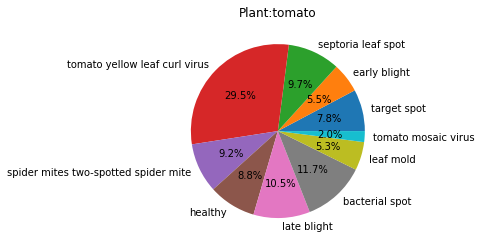

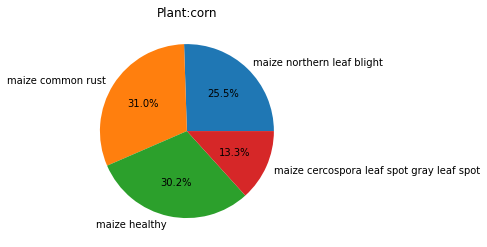

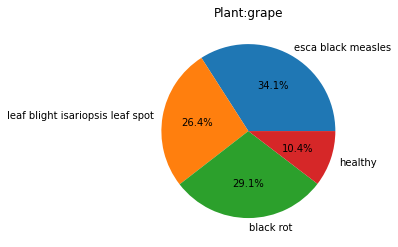

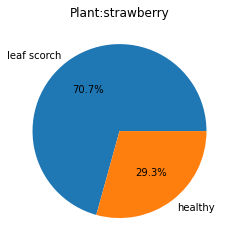

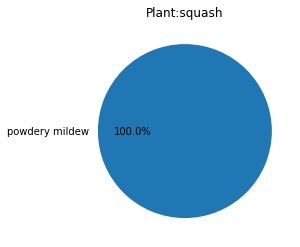

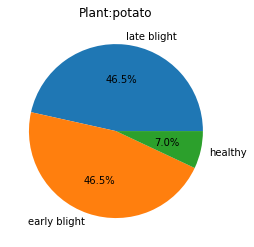

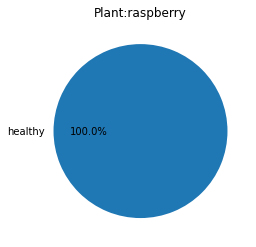

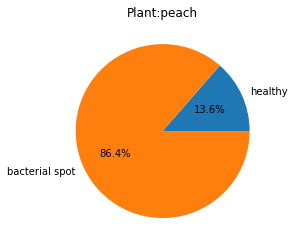

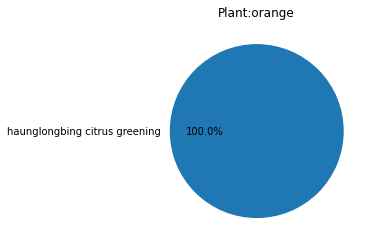

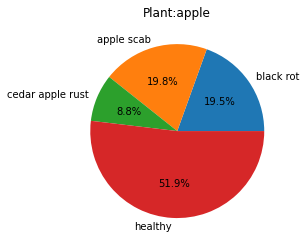

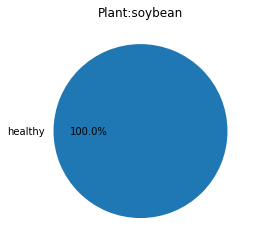

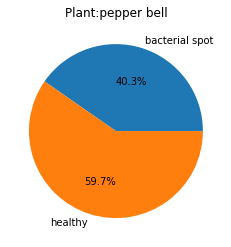

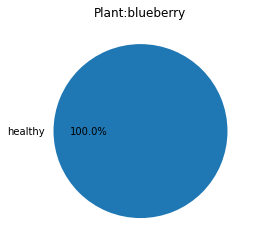

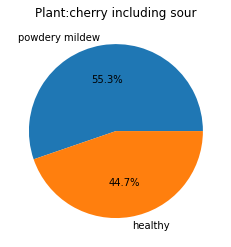

In [ ]:
plant_disease_dict = {}

for i in range(len(label2cat.keys())):
    count_i = np.count_nonzero(labels==i)
    labels_processed = label2cat[i].lower().split('_') 
    labels_processed = [x.strip(string.punctuation) for x in labels_processed if x]
    if labels_processed[0] == 'pepper':
      plant_type = ' '.join(labels_processed[0:2])
    elif labels_processed[0] == 'cherry':
      plant_type = ' '.join(labels_processed[0:3])
    else:
      plant_type = labels_processed[0]
    
    if labels_processed[0] == 'pepper':
      disease = ' '.join(labels_processed[2:])
    elif labels_processed[0] == 'cherry':
      disease = ' '.join(labels_processed[3:])
    else:
      disease = ' '.join(labels_processed[1:])
    if plant_type not in plant_disease_dict.keys():
        plant_disease_dict[plant_type] = {}
    plant_disease_dict[plant_type][disease] = count_i
    
for plant_type in plant_disease_dict.keys():
  disease_count = []
  disease_labels = []
  for disease in plant_disease_dict[plant_type].keys():
      disease_count.append(plant_disease_dict[plant_type][disease])
      disease_labels.append(disease)
  plt.pie(np.array(disease_count), labels = np.array(disease_labels), autopct='%1.1f%%')
  plt.title('Plant:{}'.format(plant_type))
  plt.show()

In [ ]:
images = images.astype(dtype=np.float32)
images, labels = augment_data(images, labels)
images

array([[[[0.5805664 , 0.5332031 , 0.5727539 ],
         [0.6352539 , 0.5883789 , 0.6274414 ],
         [0.60791016, 0.5605469 , 0.60009766],
         ...,
         [0.4038086 , 0.35302734, 0.39208984],
         [0.48632812, 0.43530273, 0.47460938],
         [0.5410156 , 0.49023438, 0.5292969 ]],

        [[0.60009766, 0.5527344 , 0.59228516],
         [0.6352539 , 0.5883789 , 0.6274414 ],
         [0.63916016, 0.59228516, 0.63134766],
         ...,
         [0.41967773, 0.36865234, 0.40795898],
         [0.5019531 , 0.45092773, 0.49023438],
         [0.48242188, 0.43139648, 0.47070312]],

        [[0.63134766, 0.58447266, 0.62353516],
         [0.60791016, 0.5605469 , 0.60009766],
         [0.66259766, 0.61572266, 0.65478516],
         ...,
         [0.46655273, 0.41577148, 0.45483398],
         [0.43139648, 0.3803711 , 0.41967773],
         [0.43920898, 0.3881836 , 0.42749023]],

        ...,

        [[0.7373047 , 0.67822266, 0.6982422 ],
         [0.77246094, 0.7138672 , 0.73339844]

In [ ]:
images.shape

(13167, 128, 128, 3)

Visualizing the labels

In [ ]:
print('Number of unique labels:', len(label2cat.values()))
print('List of values:', list(label2cat.values()))
tempLabels = labels.copy()
label2health = {}
label2health['healthy'] = []
label2health['unhealthy'] = []
# {'healthy':[], 'unhealthy':[]}
 
lab = [label2cat[l] for l in sorted(set(labels))]
for i in range(len(lab)): #i: 0->37
 if lab[i].endswith('healthy'):
   label2health['healthy'].append(i)
 else:
   label2health['unhealthy'].append(i)

for i in range(tempLabels.shape[0]): #i:0->9756
  if tempLabels[i] in label2health['healthy']:
    tempLabels[i]=1
  elif tempLabels[i] in label2health['unhealthy']: # else:
    tempLabels[i]=0
n_classes = len(label2health)



Number of unique labels: 38
List of values: ['Tomato___Target_Spot', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Strawberry___Leaf_scorch', 'Squash___Powdery_mildew', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Potato___Late_blight', 'Raspberry___healthy', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Peach___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Strawberry___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Tomato___healthy', 'Potato___Early_blight', 'Apple___Black_rot', 'Potato___healthy', 'Soybean___healthy', 'Pepper,_bell___Bacterial_spot', 'Tomato___Late_blight', 'Blueberry___healthy', 'Apple___Apple_scab', 'Pepper,_bell___healthy', 'Tomato___Bacterial_spot', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Apple___Cedar_apple_rust', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___healthy', 'Grape___healthy', 'T

Splite the data into training and testing splits to train the model and check its accuracy respectively.

In [ ]:
print("[INFO] Splitting data to train, test")
x_train, y_train, x_test, y_test = split_train_test(images, tempLabels)
y_train = np.eye(n_classes)[y_train]
y_test = np.eye(n_classes)[y_test]
print('Training data shape:', x_train.shape)
print('Testing data shape', x_test.shape)

[INFO] Splitting data to train, test
Training data shape: (9876, 128, 128, 3)
Testing data shape (3291, 128, 128, 3)


Play around with the EPOCHS and the INIT_LR parameters (but try to make well-motivated changes, not random fiddling). Run the model once with the given parameters, and analyze the training curves. EPOCHS is the number of training runs of our deep learning model and the INIT_LR is the initial learning rate for the model. BS is the batch size which is 32 in this case. **Note: When training the model, you may run out of ram, just rerun the notebook**.

In [ ]:
EPOCHS = 4
BS = 16
width=128
height=128
depth=3
INIT_LR = 1e-6

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1

model.add(Conv2D(64, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(n_classes))
model.add(Activation("softmax"))

Model Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 112896)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 225794    
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0

In [ ]:
# train the network
print("[INFO] training network...")
model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(learning_rate=INIT_LR), 
              metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=BS,
                    validation_data=(x_test, y_test),
                    epochs=EPOCHS, verbose=1)

[INFO] training network...
Epoch 1/4
618/618 [==============================] - 50s 10ms/step - loss: 0.6196 - accuracy: 0.7242 - val_loss: 0.5879 - val_accuracy: 0.7290
Epoch 2/4
618/618 [==============================] - 6s 10ms/step - loss: 0.5898 - accuracy: 0.7198 - val_loss: 0.5594 - val_accuracy: 0.7290
Epoch 3/4
618/618 [==============================] - 6s 9ms/step - loss: 0.5565 - accuracy: 0.7270 - val_loss: 0.5336 - val_accuracy: 0.7317
Epoch 4/4
618/618 [==============================] - 6s 9ms/step - loss: 0.5360 - accuracy: 0.7303 - val_loss: 0.5121 - val_accuracy: 0.7472


Plot the train and val curve

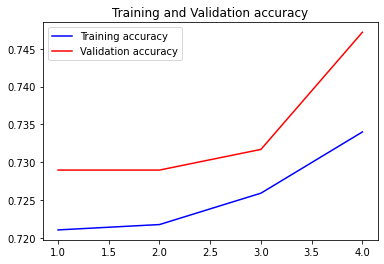

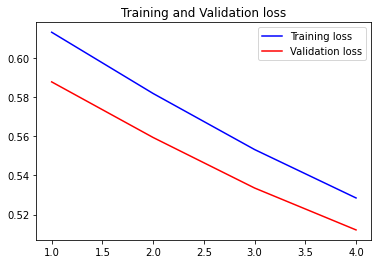

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy 
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


Model Accuracy

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
103/103 [==============================] - 1s 8ms/step - loss: 0.5121 - accuracy: 0.7472
Test Accuracy: 74.71892833709717


### My Experiments

Use this cell to document your experiments. This will allow us to see the method behind your madness, so to speak. In each experiment, describe the architecture/hyperparameters you used, along with accuracy of train and test. Describe what *you* think is happening (underfitting, overfitting, etc) by analyzing the training curves like we taught you. Then make some small changes and do this again.

A hint to get you started: if the loss doesn't decrease at all (or very slowly), what is wrong with the step size in gradient descent?

#### Ex 1
Current params -  baseline

Problem - 

Solution - 

#### Ex 2
Current params -  

Problem - 

Solution - 

#### Ex 3
Current params -  

Problem - 

Solution - 

.
.
.

In [ ]:
conv_layer1_filters, biases = model.layers[0].get_weights()
conv_layer1_filters.shape

(3, 3, 3, 64)

In [ ]:
def contrast_scale(x):
  x = (x - x.min())/(x.max() - x.min())
  return x
contrast_scale(conv_layer1_filters[:,:,:,:]).shape     

(3, 3, 3, 64)

(8, 8)


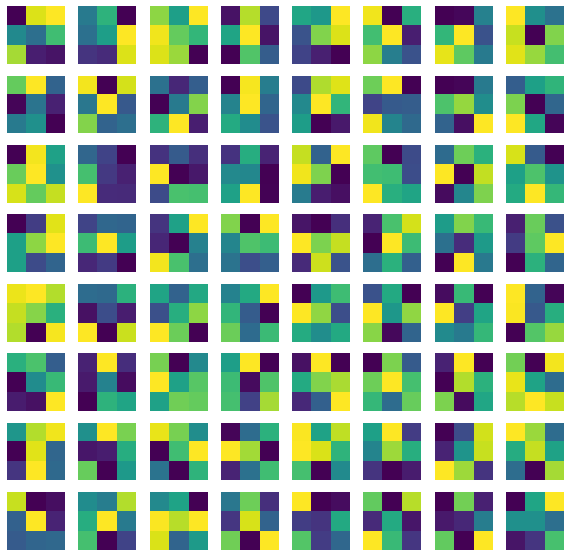

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(10,10))
i = j = 0
print(axes.shape)
for row in axes:
  j = 0
  for col in row:
    current_filter = contrast_scale(conv_layer1_filters[:,:,:,i*8+j])[:,:,0]
    col.imshow(current_filter)
    col.axis('off')
    j += 1
  i += 1
plt.show()

## Project Ideas:
1. (Project direction options: 

1) plant type classification

2) healthy vs unhealthy plants classification 

3) plant+healthy/unhealthy classication 

Note: soybean, raspberry and blueberry only have healthy data, whereas orange and squash only have unhealthy data
2. More types of data augmentation?


In [ ]:
lab = [label2cat[l] for l in labels]

result=[]
for item in lab:
 if item.endswith('healthy')==0:
   result.append('Diseased Leaf Specimen')
 else:
   result.append('Healthy Leaf Specimen')
result

['Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 'Diseased Leaf Specimen',
 

In [ ]:
variety=[]
for item in lab:
 variety.append(item.split('_', 1)[0])
variety

['Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',
 'Tomato',